# Work To Do

1. load images
2. resiz images
3. def model
4. load mdel
5. def gram matrix
6. noramlize images
7. compute content loss, style loss
8. compute total loss and backward
9. save image(result)

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.utils as utils 
from torch.autograd import Variable

import copy
import cv2

In [3]:
# Constants for the Image
CONTENT_IMG = "content.jpg"
STYLE_IMG = "style.jpg"

STEPS = 500
MODEL = 'vgg19'

IMSIZE = 512 if torch.cuda.is_available() else 128

MEAN=[0.485, 0.456, 0.406]
STD=[0.229, 0.224, 0.225]

CNTWEIGHT = 1
STLWEIGHT = 1000

In [4]:
# Function for the Image
    #1. pil->tensor
convert = transforms.Compose([
    transforms.Resize(IMSIZE),
    transforms.ToTensor()
])
'''이렇게만 하면, 같은 사이즈의 이미지만 처리할 수 있다. 
    더 확장하려면 mean 을 -,+ 과정을 거쳐야 함'''
    # 2. tensor -> pil
reconvert = transforms.ToPILImage()


#이미지 로드 함수
def imageLoad(image_name):
    img = Image.open(image_name)
    img = convert(img).unsqueeze(0).clone()
    return img.to(device, torch.float)

def showImage(tensor):
    image = tensor.cpu().clone() #not to change original image
    image = image.squeeze(0) #delete b  
    image = reconvert(image)
    plt.imshow(image) #image show

In [5]:
def gramMatrix(img):
    b, c, h, w = img.size() #batch size(1), chanel, height, width
    features = img.view(b*c, h*w) 
    gram = torch.mm(features, features.t())
    return gram

In [6]:
def contentLoss(targetList,content_layers_target, input_img_content):
    loss = 0
    for i in targetList:
        loss += F.mse_loss(content_layers_target[0], input_img_content[0])/2.0
        ##print("content loss", loss, "input_img", input_img_content[0][0][1])
    return loss

In [7]:
def styleLoss(targetList, style_layers_target, input_img_style, vgg):
    loss = 0
    j = 0
    for i in targetList:
        n = vgg[i].out_channels
        m = vgg[i].kernel_size[0] * vgg[i].kernel_size[1]
        loss +=F.mse_loss(gramMatrix(style_layers_target[j]), gramMatrix(input_img_style[j]))/(n*n*m*m*4)
        ##print("style loss", loss, "input_img", input_img_style[j][0][1])
        j +=1
    return loss * 0.2

In [46]:
def makeNewImg( noise_img, vgg, content_layers_target, style_layers_target, input_img_content, input_img_style, content_layers,  style_layers):
    optimizer = optim.SGD([noise_img.requires_grad_()], lr=10)
    run = [0]
    while run[0] < STEPS:
        
        def closure():
            vgg(noise_img)
            optimizer.zero_grad()
            content_loss = contentLoss(content_layers,content_layers_target, input_img_content)
            style_loss = styleLoss(style_layers, style_layers_target, input_img_style, vgg)
            total_loss = content_loss * CNTWEIGHT + style_loss * STLWEIGHT 
            ##total_loss = total_loss.requires_grad_(True)
            total_loss.backward(retain_graph=True)#retain_graph=True
            ##print(total_loss)


            if run[0] % 20 == 0:
                print('Step - {}, Content loss - {}, Style loss - {}, Total Loss - {}'.format(run[0], content_loss.item(), style_loss.item(), total_loss.item()));
                ##new_img = out_img.data.cpu().squeeze().permute(1,2,0).numpy();
                ##cv2.imwrite(os.path.join('result', str(count) + '.png'), new_img*255);
            run[0] +=1
            return content_loss + style_loss
        
        optimizer.step(closure)
    return noise_img

In [ ]:
if __name__ == '__main__':
    
    #cuda load
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    #images load
    content_img = imageLoad(CONTENT_IMG)
    style_img = imageLoad(STYLE_IMG)    
    plt.figure()
    showImage(style_img)
    plt.figure()
    showImage(content_img)
    
    #model load
    vgg = models.vgg19(pretrained=True).features.eval().to(device)
    
    #white noise image
    noise_img = torch.randn(content_img.data.size(), device=device)
    
    #normalize 
    normalization = transforms.Normalize(MEAN,STD)
    
    #initialize losses
    content_layers = [3]#cov4_2
    style_layers = [0, 5, 10, 19, 28]#conv1_1, conv2_1, conv3_1, conv4_1, conv5_1
    content_layers_target = []
    style_layers_target = []
    input_img_content = []
    input_img_style = []
    
    for i in content_layers:
        tmp_model = vgg[:(i+1)]
        target = tmp_model(content_img).detach()
        content_layers_target.append(target)
        input_target = tmp_model(noise_img)
        input_img_content.append(input_target)
    for i in style_layers:
        tmp_model = vgg[:(i+1)]
        target = tmp_model(style_img).detach()
        style_layers_target.append(target)
        input_target = tmp_model(noise_img)
        input_img_style.append(input_target)
        
    print(len(content_layers_target))
    print(len(style_layers_target)) 

    ##content_losses = [ContentLoss(vgg(content_img).detach()) for i in content_layers]
    ##style_losses = [StyleLoss(vgg(style_img).detach()) for i in style_layers]
    
    #compute total loss and make result image
    #optimizer = optim.SGD([noise_img.requires_grad_()], lr=10)#[noise_img.requires_grad_()]# LBFGS is a kind of alogorithms.it makes computation more easier
    ##noise_img = Variable(noise_img, requires_grad = True)
    makeNewImg(noise_img, vgg, content_layers_target, style_layers_target, input_img_content, input_img_style, content_layers,  style_layers);
    ##makeOutput(vgg, noise_img, style_losses, content_losses)


1
5
Step - 0, Content loss - 2.946070432662964, Style loss - 5323.357421875, Total Loss - 5323360.5
Step - 20, Content loss - 2.946070432662964, Style loss - 5323.357421875, Total Loss - 5323360.5
Step - 40, Content loss - 2.946070432662964, Style loss - 5323.357421875, Total Loss - 5323360.5


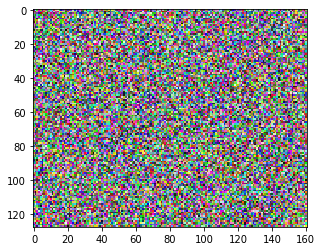

In [38]:
plt.figure()
showImage(noise_img)

In [ ]:
'''다음주 와서 할 일: input_img가 정확히 잘 들어가는지 보기. 특히 loss구하는 부분에서 새로 변경된 input_img가 들어가는지 확인할 것!'''

In [22]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()# call sueprclass' init method
        self.target = target##.detach()
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        print(self.loss)
        return input 

In [23]:
class StyleLoss(nn.Module):
    def __init__(self, target):
        super(StyleLoss, self).__init__()
        self.target = gramMatrix(target)##.detach()
    def forward(self, input):
        gram_input = gramMatrix(input)
        self.loss = F.mse_loss(gram_input, self.target)
        print(self.loss)
        return input 

In [15]:
def makeOutput(vgg, input_img, style_losses, content_losses):
    run = [0]
    print(content_losses)
    print(style_losses)
    while run[0] <= STEPS:
        
        def closure():
            input_img.data.clamp_(0, 1)##
            vgg(input_img)
            optimizer.zero_grad()
            style_total = 0
            content_total = 0
            for i in content_losses:
                content_total += i.loss
            for i in style_losses:
                style_total += i.loss
            content_total = content_total * CNTWEIGHT
            style_total  = style_total * STLWEIGHT
            total_loss = style_total + content_total 
            total_loss.backward()
            if num == 100:
                print("run {}:".format(num))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(style_total.item(), content_total.item()))
                print()
            return style_total + content_total
                
        optimizer.step(closure)
        
    return input_img    